In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import collections

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1304,362,134,1962
2017-04-16,1457,336,188,2202
2017-04-17,1353,286,177,2007
2017-04-18,2767,378,312,3656
2017-04-19,3135,443,313,4121


In [6]:
'Average tweet number per day: {:.0f}'.format(timeline['total'].mean())

'Average tweet number per day: 3163'

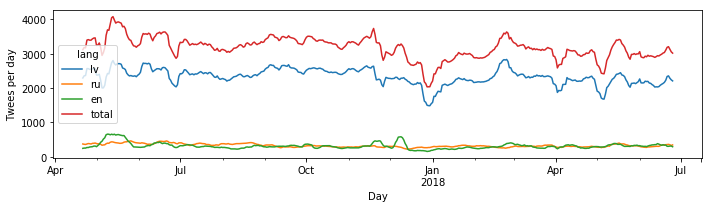

In [7]:
_ = (
    timeline
    .rolling(window=7).mean()
    .plot(figsize=(10, 3))
)

_.set(xlabel='Day', ylabel='Twees per day')


_.figure.tight_layout()
_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Source statistics

In [8]:
sources = (
    pd.read_csv(
        'rehydrated_tweets_source_counts.csv',
        index_col=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
        ],
        usecols=[
            'source_pretty',
            'total_count', 'total_share', 'tracked_source_share',
            'other_lang_count', 'other_lang_share',
            'lang',
            'source_lang_count', 'source_lang_share'
        ],
    )
    .unstack('lang', fill_value=0)
)

In [9]:
sources = (
    sources.reorder_levels([1, 0], axis=1)
    .reset_index()
    .set_index('source_pretty').sort_values('total_count', ascending=False)[
        [
            'total_count', 'total_share', 'tracked_source_share',
            'lv', 'ru', 'en',
            'other_lang_count', 'other_lang_share',
        ]
    ]
    .sort_values('total_count', ascending=False)
)

In [10]:
sources

lang                total_count total_share tracked_source_share  \
                                                                   
source_pretty                                                      
Twitter Web Client       474729       34.3%                51.8%   
Twitter for Android      230014       16.6%                 8.3%   
Twitter for iPhone       207167       15.0%                14.1%   
TweetDeck                105235        7.6%                91.8%   
TVNET Login               58353        4.2%                96.7%   
dlvr.it                   45769        3.3%                98.4%   
Facebook                  36700        2.7%                95.1%   
Foursquare                30929        2.2%                 0.0%   
Instagram                 24872        1.8%                 1.7%   
SKATIES                   23079        1.7%                98.0%   

lang                               lv                                  ru  \
                    source_lang_count source_lang_share source_lang_count   
source_pretty                                                               
Twitter Web Client             389495             82.0%             15094   
Twitter for Android            155044             67.4%             22624   
Twitter for iPhone             124584             60.1%             33083   
TweetDeck                      103132             98.0%                75   
TVNET Login                     26496             45.4%             31172   
dlvr.it                         45235             98.8%               134   
Facebook                        13864             37.8%             21074   
Foursquare                      24465             79.1%               219   
Instagram                        8863             35.6%              2453   
SKATIES                         23063             99.9%                 0   

lang                                                 en                    \
                    source_lang_share source_lang_count source_lang_share   
source_pretty                                                               
Twitter Web Client               3.2%             40051              8.4%   
Twitter for Android              9.8%             35093             15.3%   
Twitter for iPhone              16.0%             32110             15.5%   
TweetDeck                        0.1%              1484              1.4%   
TVNET Login                     53.4%                23              0.0%   
dlvr.it                          0.3%               129              0.3%   
Facebook                        57.4%               451              1.2%   
Foursquare                       0.7%              1887              6.1%   
Instagram                        9.9%              8285             33.3%   
SKATIES                             0                 0                 0   

lang                other_lang_count other_lang_share  
                                                       
source_pretty                                          
Twitter Web Client             30089             6.3%  
Twitter for Android            17253             7.5%  
Twitter for iPhone             17390             8.4%  
TweetDeck                        544             0.5%  
TVNET Login                      662             1.1%  
dlvr.it                          271             0.6%  
Facebook                        1311             3.6%  
Foursquare                      4358            14.1%  
Instagram                       5271            21.2%  
SKATIES                           16             0.1%

In [11]:
sources.to_latex('figures/rehydrated_tweets_source_counts.tex')

# Language usage 

In [12]:
rehydrated_tweets_language_counts = (
    pd.read_csv('rehydrated_tweets_language_counts.csv', index_col='lang')
)

In [13]:
rehydrated_tweets_language_counts

,count
lang,
en,138171
lv,1017221
ru,144367


In [14]:
(
    (rehydrated_tweets_language_counts / timeline['total'].sum())
    .style.format({'count': '{:.1%}'})
)

,count
lang,
en,10.0%
lv,73.6%
ru,10.4%


In [15]:
_ = (timeline['total'].sum() - rehydrated_tweets_language_counts.sum())[0]

__ = _ / rehydrated_tweets_language_counts.sum()[0]
f'{_}, {__:.1%}'

'82592, 6.4%'

In [16]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

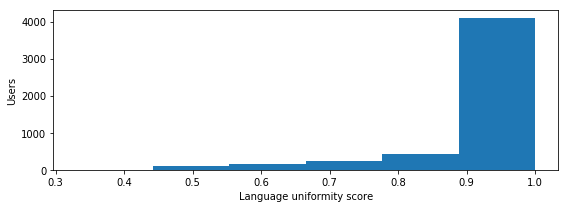

In [17]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=6, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [18]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
3854,7,7,7,30,0.33
2000,13,16,14,74,0.37
1591,16,20,14,97,0.40
4451,7,3,7,24,0.41
4373,4,5,3,25,0.42


# Language preference

## Monolingual

In [19]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

lv    1560
ru     133
en     317
dtype: int64

## Multilingual

In [20]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,2240,338,492
2.0,551,231,2312
3.0,96,276,123


# Topics

In [21]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

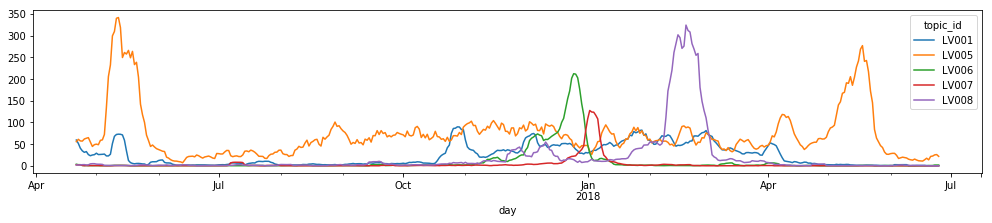

In [22]:
(
    relevance_judgments_count_by_day[
        ['LV001', 'LV005', 'LV006', 'LV007', 'LV008']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

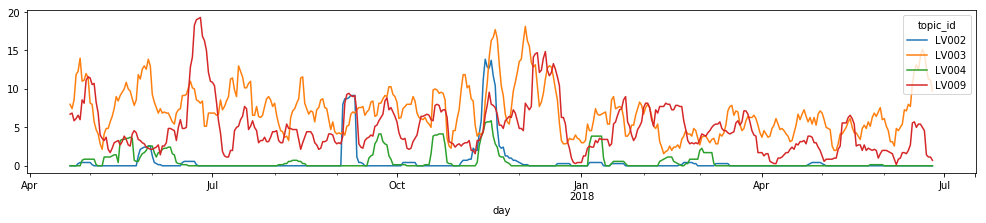

In [23]:
(
    relevance_judgments_count_by_day[['LV002', 'LV003', 'LV004', 'LV009']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [24]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [25]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets             Users            
Language             Total lv, ru, en     lv    ru    en    lv    ru    en
day        topic_id                                                       
2017-04-15 LV001        74         73   0.88  0.07  0.05  0.81  0.08  0.10
2017-04-16 LV001        76         76   0.93  0.01  0.05  0.92  0.02  0.05
2017-04-17 LV001        67         63   0.84  0.14  0.02  0.80  0.14  0.06
2017-04-18 LV001        46         46   0.91  0.09  0.00  0.89  0.10  0.01
2017-04-19 LV001        24         24   0.75  0.08  0.17  0.86  0.08  0.06

In [26]:
relevance_judgments_lang_pref_by_day['Counts', 'Total'].groupby(level='topic_id').sum()

topic_id
LV001     9795
LV002      215
LV003     2990
LV004      225
LV005    28069
LV006     3724
LV007     1483
LV008     7569
LV009     2078
LV010     2340
LV011     1265
LV012      496
LV013      796
LV014     1033
LV015     1217
LV016     7602
Name: (Counts, Total), dtype: int64

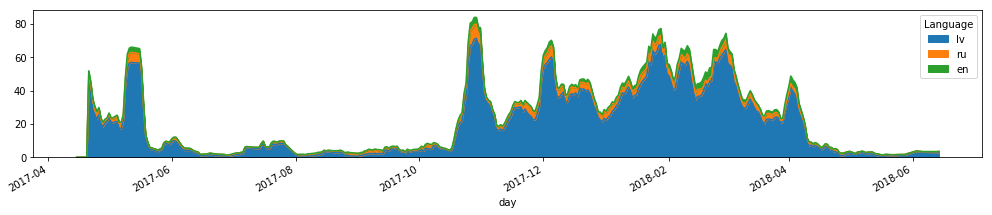

In [27]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV001'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [28]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day', 'tweet_lang'],
    parse_dates=['day']
)

relevance_judgments_lang_pref = _

In [29]:
relevance_judgments_lang_pref.loc[['LV005']].head()

r_lv  r_ru  r_en
topic_id day        tweet_lang                  
LV005    2018-05-12 lv          0.67  0.01  0.33
         2018-05-08 lv          0.67  0.01  0.33
         2018-05-06 lv          0.67  0.01  0.33
         2018-05-15 und         0.67  0.01  0.33
         2018-05-10 lv          0.67  0.01  0.33

In [30]:
_ = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)

_total = _.sum(axis='columns')

__ = _.divide(_total, axis='rows')

__['total'] = _total
__.style.format({'lv': '{:.1%}', 'ru': '{:.1%}', 'en': '{:.1%}'})

__.to_latex('figures/topic_lang_counts.tex', float_format='{:.1%}'.format)

__

tweet_lang,lv,ru,en,total
topic_id,,,,
LV001,0.859465,0.096399,0.044136,9720
LV002,0.888372,0.009302,0.102326,215
LV003,0.889410,0.066354,0.044236,2984
LV004,1.000000,0.000000,0.000000,225
LV005,0.945168,0.024168,0.030664,26937
LV006,0.864835,0.046154,0.089011,3640
LV007,0.772014,0.143345,0.084642,1465
LV008,0.953562,0.039671,0.006767,7537
LV009,0.847637,0.048698,0.103664,2074


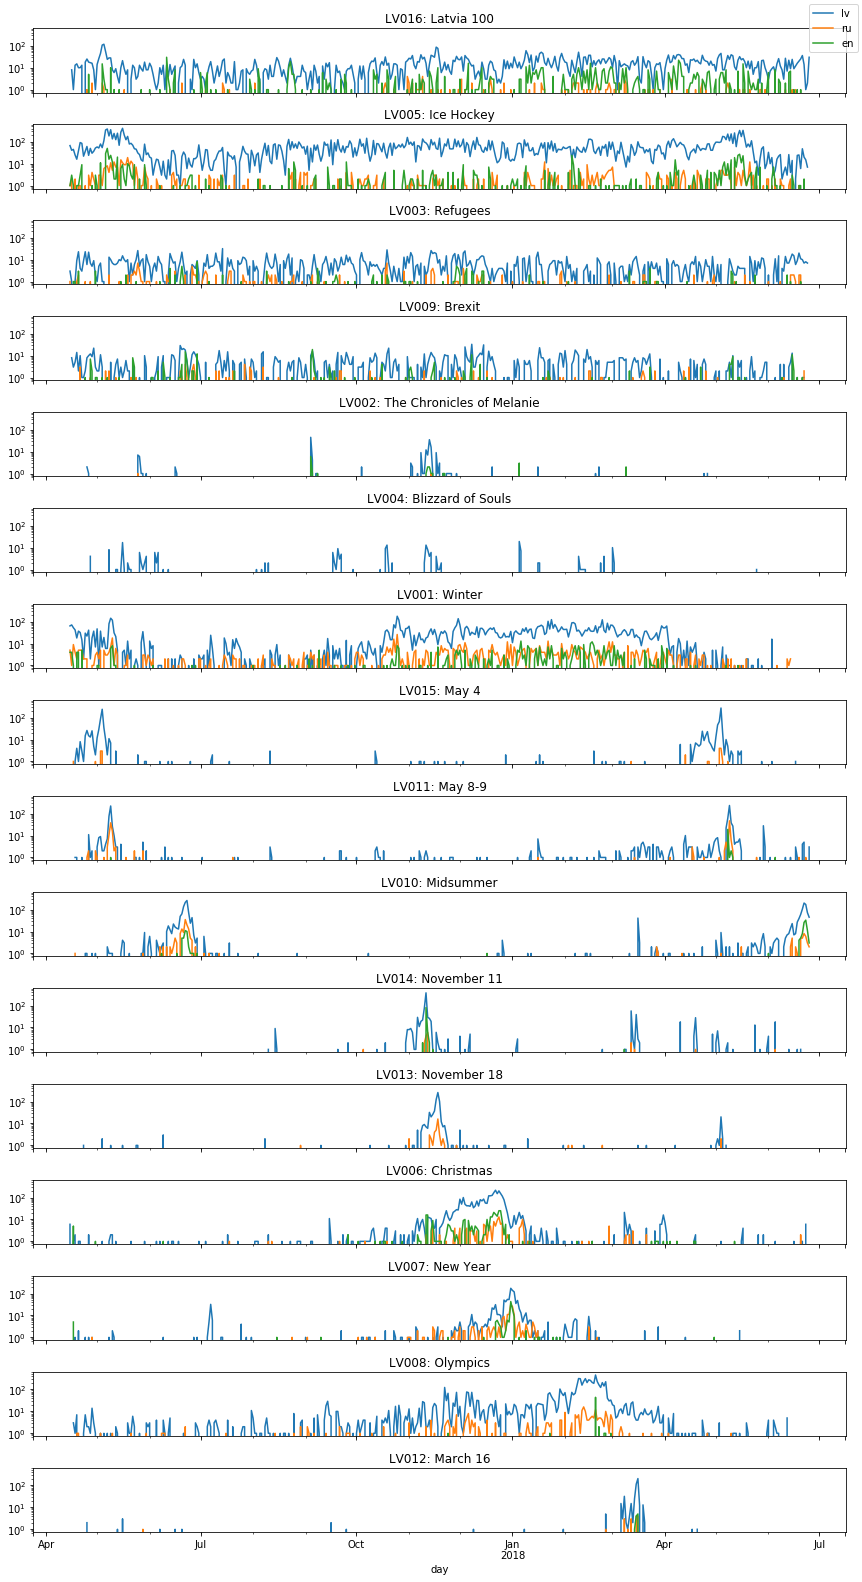

In [31]:
_data = (
    relevance_judgments_lang_pref
    .groupby(level=['topic_id', 'day' ,'tweet_lang']).size()
    .unstack('tweet_lang', fill_value=0)
    [['lv', 'ru', 'en']]
)


topics = collections.OrderedDict(
    [

        ('LV016', 'Latvia 100'),
        ('LV005', 'Ice Hockey'),
        ('LV003', 'Refugees'),
        ('LV009', 'Brexit'),
        ('LV002', 'The Chronicles of Melanie'),
        ('LV004', 'Blizzard of Souls'),

        ('LV001', 'Winter'),

        ('LV015', 'May 4'),
        ('LV011', 'May 8-9'),
        ('LV010', 'Midsummer'),
        ('LV014', 'November 11'),
        ('LV013', 'November 18'),
        ('LV006', 'Christmas'),
        ('LV007', 'New Year'),
        ('LV008', 'Olympics'),
        ('LV012', 'March 16'),
 
     ]
)

fig, axs = plt.subplots(len(topics), 1, sharex=True, sharey=True, figsize=(12, 22))

axs = axs.flatten()


for (topic, topic_title), ax in zip (topics.items(), axs):

    _ = (
        _data.loc[topic]
        .resample('1d', level='day').sum()
        .plot.line(ax=ax, logy=True, legend=False, title=f'{topic}: {topic_title}')
    );
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.tight_layout()
fig.savefig('topic_timeline.pdf')